In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#from dask_ml.xgboost import XGBRegressor
from dask_ml.linear_model import LinearRegression
from dask_ml.linear_model import LogisticRegression

import dask
from dask.distributed import Client
client = Client(processes=False)  #memory_limit='16GB', 

import xarray as xr
from dask.diagnostics import ProgressBar
#from aux.plot import Map

#from sklearn_xarray import wrap

/home/srvx11/lehre/users/a1303583/.conda/envs/py3/lib/python3.7/site-packages/distributed/dashboard/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [7]:
client

Client Scheduler: inproc://131.130.157.5/37031/7 Dashboard: http://localhost:46484/status,Cluster Workers: 1 Cores: 32 Memory: 203.20 GB


In [8]:
import sys
print(sys.executable)

/home/srvx11/lehre/users/a1303583/.conda/envs/py3/bin/python


cluster

In [9]:
static = xr.open_dataset('../data/danube/era5_slt_z_slor_lsm_stationary_field.nc')
static

<xarray.Dataset>
Dimensions:    (latitude: 13, longitude: 53, time: 31)
Coordinates:
  * longitude  (longitude) float32 7.0 7.25 7.5 7.75 ... 19.25 19.5 19.75 20.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
  * time       (time) datetime64[ns] 2000-01-01T23:00:00 ... 2000-01-31T23:00:00
Data variables:
    slt        (time, latitude, longitude) float32 ...
    z          (time, latitude, longitude) float32 ...
    slor       (time, latitude, longitude) float32 ...
    lsm        (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.4rc4 (http://code.zmaw.d...
    Conventions:  CF-1.6
    history:      Thu May 30 01:39:36 2019: cdo dayavg /home/srvx11/lehre/use...
    CDO:          Climate Data Operators version 1.6.4rc7 (http://code.zmaw.d...

In [13]:
era5 = open_data(data_path, kw='era5')
glofas = open_data(data_path, kw='glofas_ra')

NameError: name 'open_data' is not defined

### Interpolation step

In [9]:
era5 = era5.interp(latitude=glofas.latitude, longitude=glofas.longitude)
era5

<xarray.Dataset>
Dimensions:    (latitude: 30, level: 3, longitude: 130, time: 13514)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
  * level      (level) float64 850.0 700.0 500.0
  * latitude   (latitude) float64 49.95 49.85 49.75 49.65 ... 47.25 47.15 47.05
  * longitude  (longitude) float64 7.05 7.15 7.25 7.35 ... 19.75 19.85 19.95
Data variables:
    cp         (time, latitude, longitude) float32 dask.array<shape=(13514, 30, 130), chunksize=(1, 30, 130)>
    tp         (time, latitude, longitude) float32 dask.array<shape=(13514, 30, 130), chunksize=(1, 30, 130)>
    lsp        (time, latitude, longitude) float32 dask.array<shape=(13514, 30, 130), chunksize=(1, 30, 130)>
    z          (time, level, latitude, longitude) float32 dask.array<shape=(13514, 3, 30, 130), chunksize=(1, 3, 30, 130)>
    t          (time, level, latitude, longitude) float32 dask.array<shape=(13514, 3, 30, 130), chunksize=(1, 3, 30, 130)>
    q          (time, level, 

### Feature engineering

In [20]:
era5 = era5.isel(time=slice(0,1000))
glofas = glofas.isel(time=slice(0,1000))

In [21]:
krems = dict(latitude=48.403, longitude=15.615)

surrounding = dict(latitude=slice(krems['latitude']+1, 
                                  krems['latitude']-1),
                   longitude=slice(krems['longitude']-1, 
                                  krems['longitude']+1))

y = glofas.interp(krems)
X = era5[['cp', 'lsp']]

X = X.sel(surrounding).sum(['latitude', 'longitude'])
xdf = X.to_dataframe()
ydf = y.drop(['latitude', 'longitude']).to_dataframe()

xdf.head()

,cp,lsp
time,,
1981-01-01,0.103353,0.060922
1981-01-02,0.054612,0.156747
1981-01-03,0.050642,0.494982
1981-01-04,0.070544,0.086476
1981-01-05,0.143328,0.159869


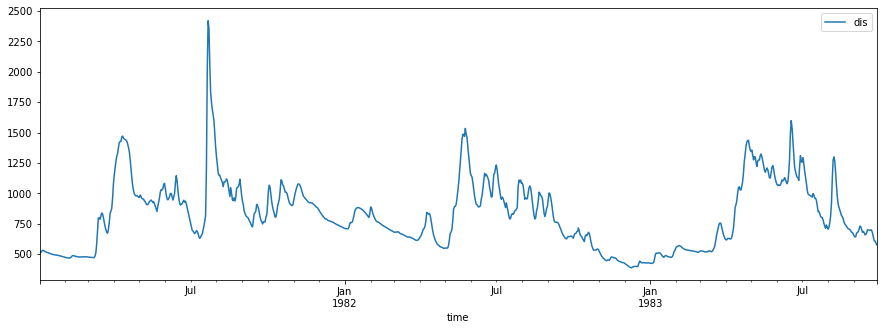

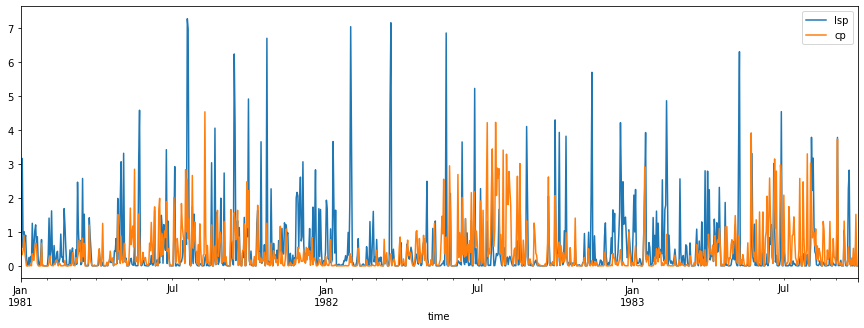

In [12]:
ydf.plot(y='dis', figsize=(15,5))
fig, ax = plt.subplots()
xdf.plot(y=['lsp', 'cp'], ax=ax, figsize=(15,5))

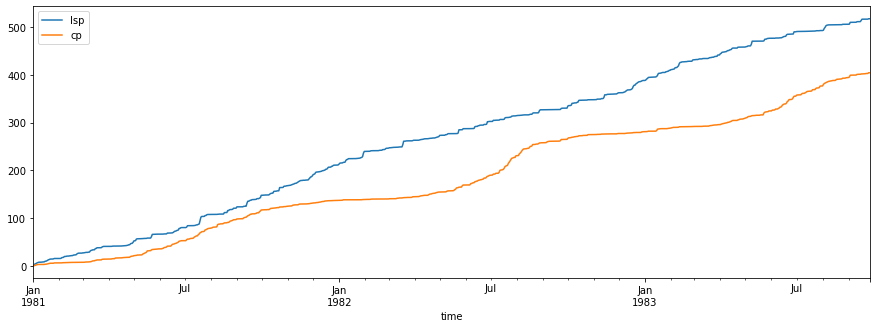

In [13]:
xdf.cumsum().plot(y=['lsp', 'cp'], figsize=(15,5))

In [14]:
merge = pd.concat([xdf, ydf], axis=1)
merge.head()

,cp,lsp,dis
time,,,
1981-01-01,0.649452,0.386786,NaN
1981-01-02,0.342051,0.997013,517.917556
1981-01-03,0.329396,3.160058,513.782622
1981-01-04,0.455418,0.542463,520.214646
1981-01-05,0.896145,1.006355,529.514214


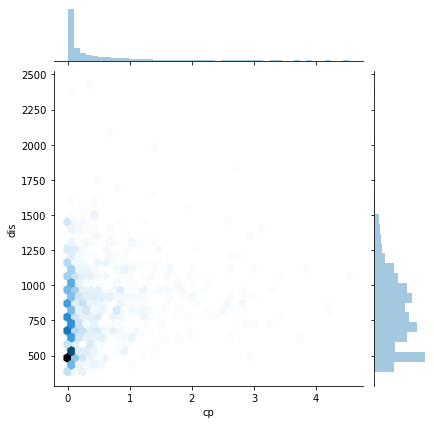

In [15]:
sns.jointplot(x='cp', y='dis', data=merge, kind='hex')

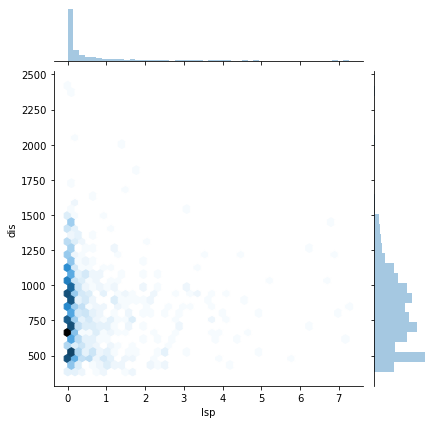

In [16]:
sns.jointplot(x='lsp', y='dis', data=merge, kind='hex')

In [17]:
def mask_dataframe(df, limit_per_variable: dict):
    for var, (lowlim, uplim) in limit_per_variable.items():
        df = df[var > lowlim]
        df = df[var < uplim]
    return df

def normalize(series):
    return series #(series-series.mean())/series.std()

def normalize_df(df):
    dic = []
    for var, d in xdf.items():
        dic.append( normalize(d) )
    return #pd.concat(dic)

## daily change in discharge 
As discharge itself has a large memory component (high autocorrelation, dependence on previous values), we can also look on the changes in discharge through time.

In [112]:
# select data of interest
y = glofas.interp(krems)
X = era5[['cp', 'lsp']]

# prepare predictor
X = X.sel(surrounding).sum(['latitude', 'longitude'])

y = y.where(y>0)

In [113]:
# normalize
X = (X - X.mean('time'))/X.std('time')
y = (y - y.mean('time'))/y.std('time')

xdf = X.to_dataframe()
ydf = y.drop(['latitude', 'longitude']).to_dataframe()

merge = pd.concat([xdf, ydf], axis=1, join='inner')

distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


In [114]:
merge.head()

,cp,lsp,dis
time,,,
1981-01-02,-0.092789,0.472864,-1.087842
1981-01-03,-0.111705,2.603755,-1.102582
1981-01-04,0.076666,0.025070,-1.079654
1981-01-05,0.735443,0.482067,-1.046505
1981-01-06,0.013768,0.205209,-1.040580


## Is there a relationship 

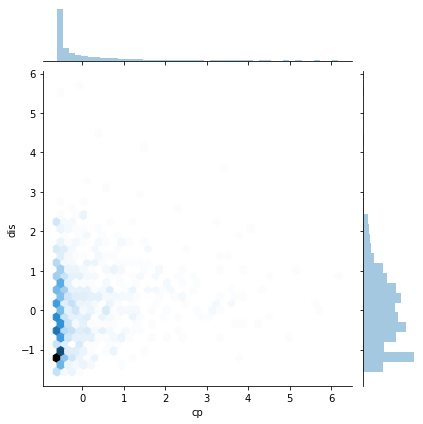

In [115]:
sns.jointplot(x='cp', y='dis', data=merge, kind='hex')

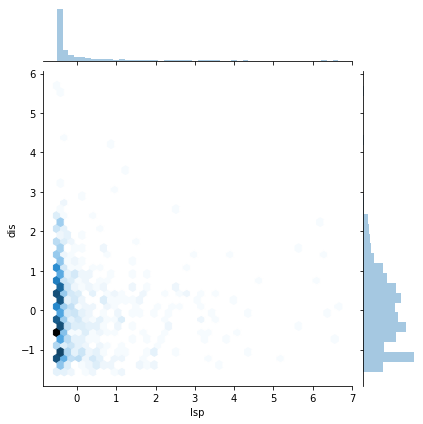

In [116]:
sns.jointplot(x='lsp', y='dis', data=merge, kind='hex')

In [ ]:
#from sklearn_xarray import wrap
#from dask_ml.xgboost import XGBRegressor
from dask_ml.linear_model import LogisticRegression

orig = xar['cp'] #.isel(latitude=0, longitude=0)
shifted = orig.shift(time=3)

merged = xr.concat([orig, shifted], dim='shift')


X = merged.isel(latitude=50, longitude=50)
y = xar['ro'].isel(latitude=50, longitude=50)

#X = merged.stack(features='shift')

#Xy = xr.concat([X, y], dim='dummy')
#Xy.coords['dummy'] = ['predictors', 'predictand']
#Xy = Xy.dropna('time')


X = Xy.sel(dummy='predictors')
y = Xy.sel(dummy='predictand', shift=0)

In [16]:

model_kws = dict(n_jobs=-1, max_iter=1, verbose=True)

pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', LinearRegression(**model_kws)),],
                verbose=True)

In [17]:
pipe

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LinearRegression(C=1.0, class_weight=None, dual=False,
                                  fit_intercept=True, intercept_scaling=1.0,
                                  max_iter=1, multi_class='ovr', n_jobs=-1,
                                  penalty='l2', random_state=None,
                                  solver='admm', solver_kwargs=None, tol=0.0001,
                                  verbose=True, warm_start=False))],
         verbose=True)

In [18]:
Xda = X.to_array(dim='features').chunk(dict(time=-1, features=-1)).data.T
yda = y.to_array().data.squeeze()

NameError: name 'X' is not defined

In [ ]:
print(Xda)   # type is dask array now for Machine Learning
print(yda.shape)

In [ ]:
with ProgressBar():
    pipe.fit(Xda, yda)

In [ ]:
Xda.shape